**<h1 align="center">Text Mining</h1>**
**<h2 align="center">Stock Sentiment: Predicting market behavior from tweets</h2>**

<a class="anchor" id="chapter1"></a>

# 1. Imports

</a>

In [124]:
#!pip install wordcloud
#!pip install nltk
#!pip install strings

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [44]:
from tqdm import tqdm

In [45]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem import WordNetLemmatizer, PorterStemmer

In [100]:
import gensim
from gensim.models import Word2Vec

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

In [46]:
# Set the style for seaborn
sns.set(style="white")

In [47]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>

In [48]:
# Check the test set
print(df_test.shape)
df_test.head()

(2388, 2)


,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [49]:
# Set id as index
df_test.set_index('id', inplace=True)

In [50]:
# Check the train set
print(df_train.shape)
df_train.head()

(9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [51]:
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")

Null values in labels = 0
Null values in text = 0


<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>

In [52]:
df_train["label"].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

In [53]:
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()

Unique labels: [0 1 2]


count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

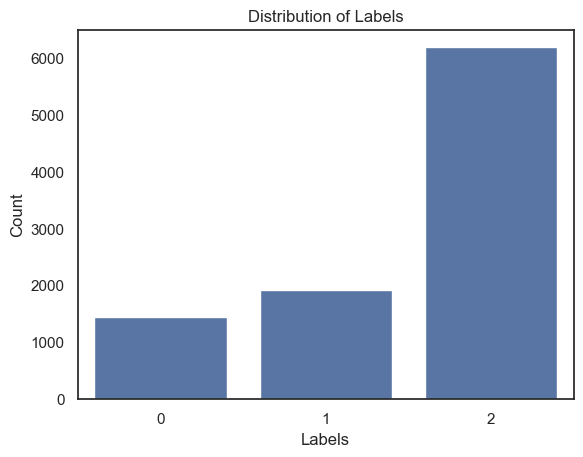

In [54]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

<Axes: ylabel='label'>

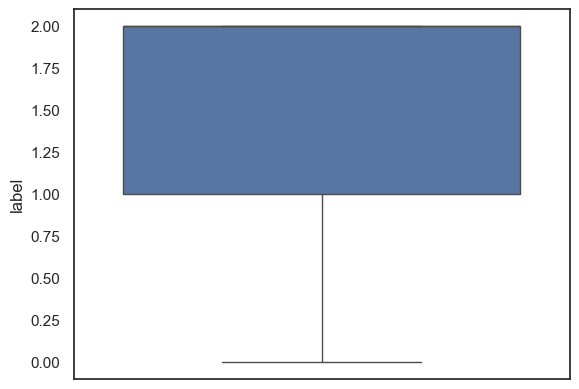

In [55]:
sns.boxplot(data=df_train['label'])

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>

In [56]:
# Fetch wordcount for each abstract
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [57]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

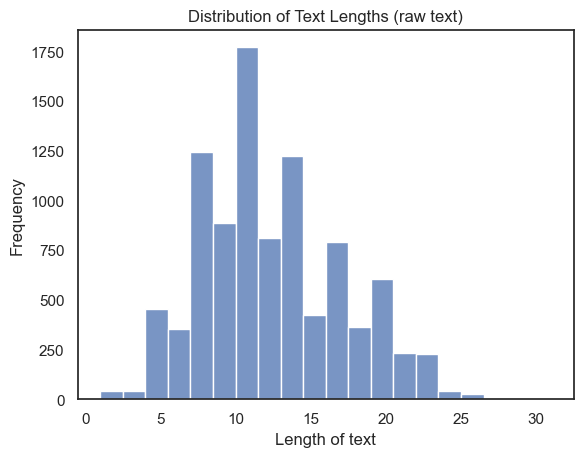

In [58]:
# Plot distribution of text length
sns.histplot(df_train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [59]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

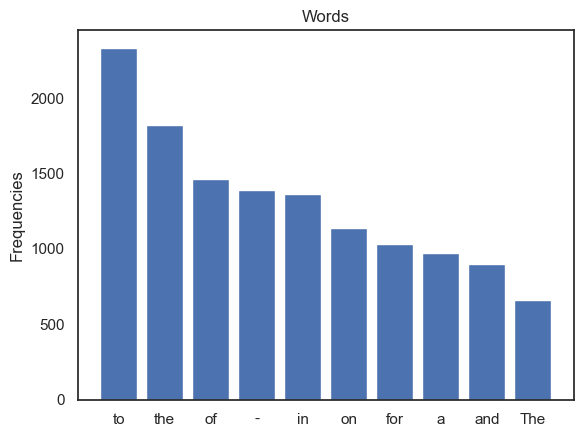

In [60]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

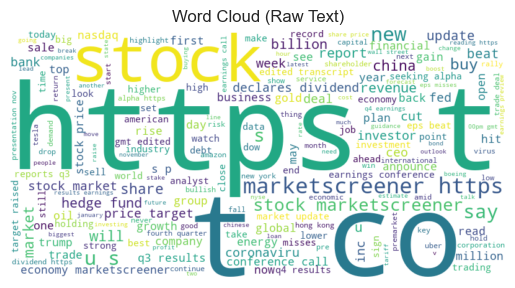

In [61]:
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>

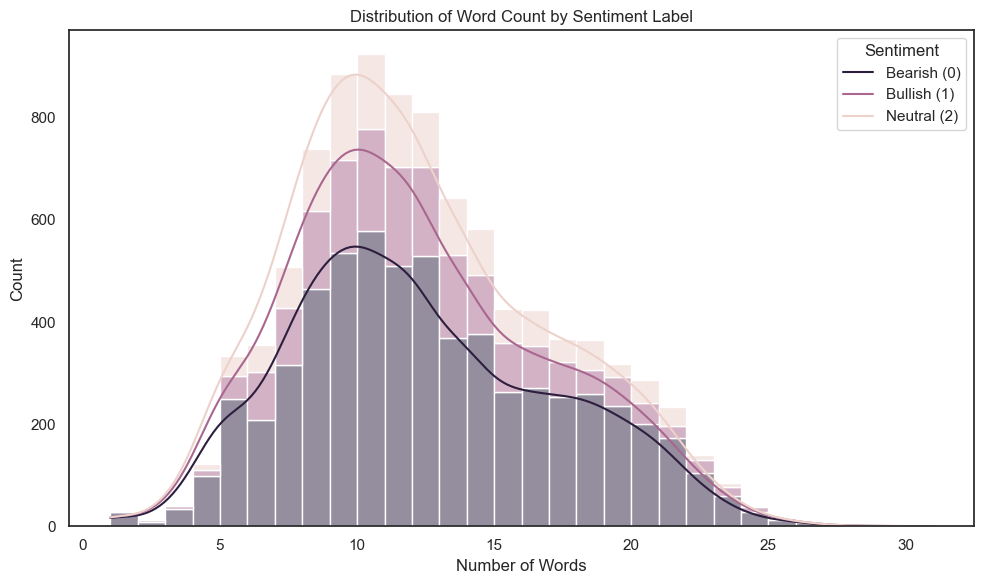

In [62]:
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.

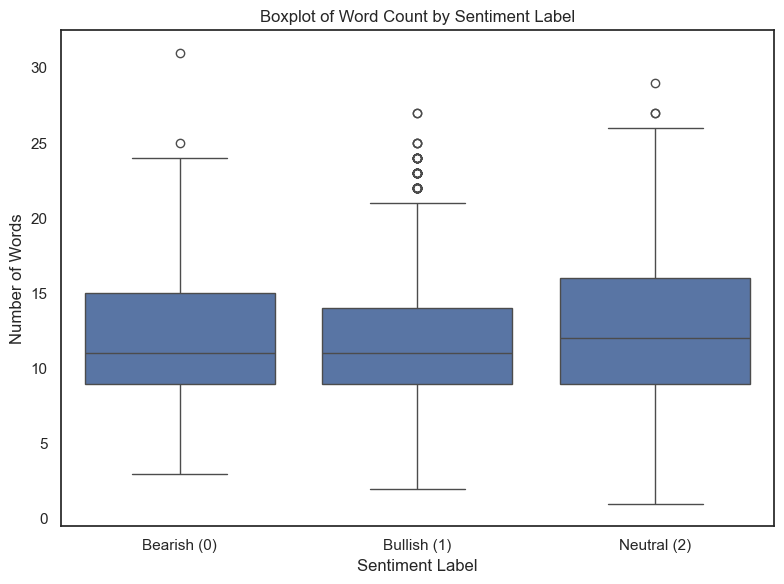

In [63]:
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [64]:
# Simple text cleaner
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"[^a-z\s]", '', text)  # keep only letters
    return text

# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)

In [65]:
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

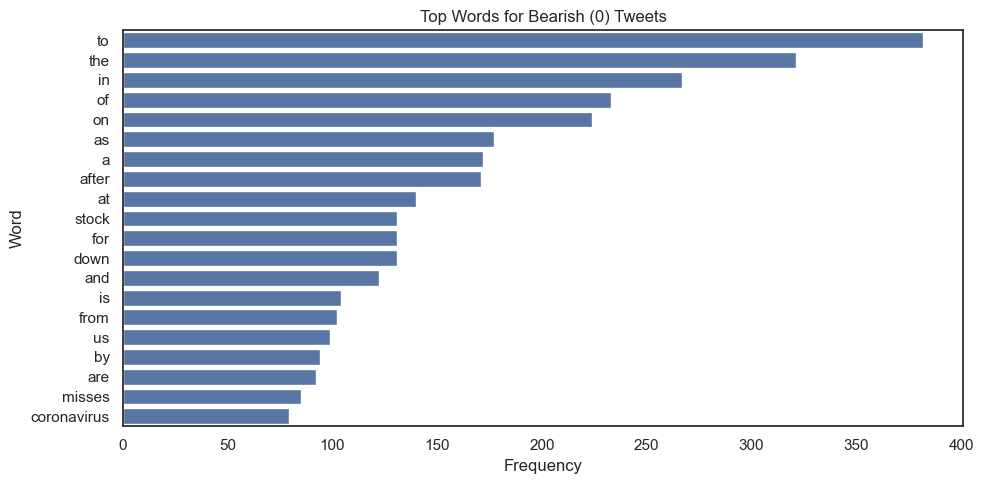

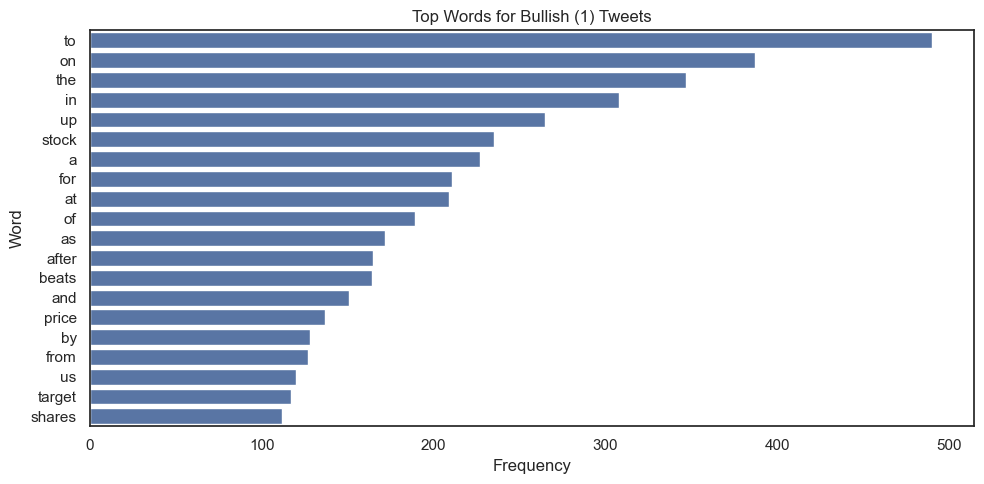

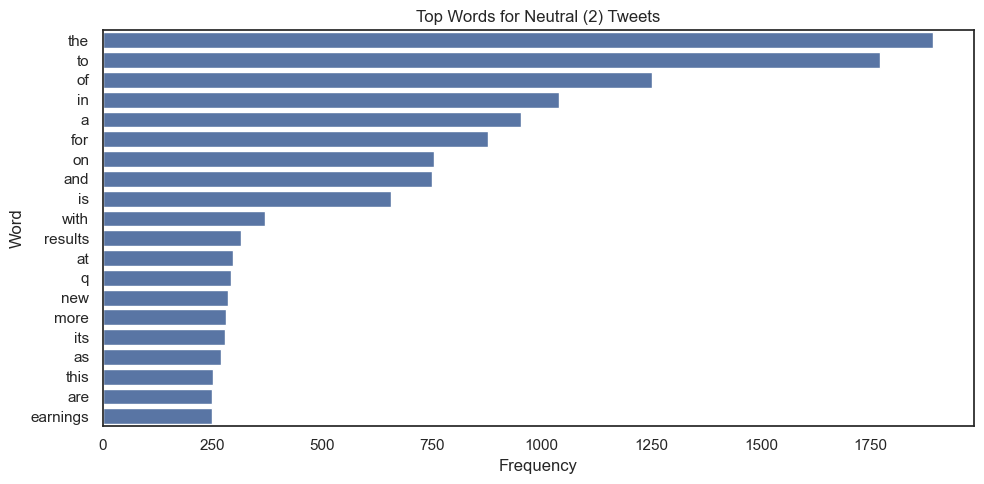

In [66]:
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')

In [67]:
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

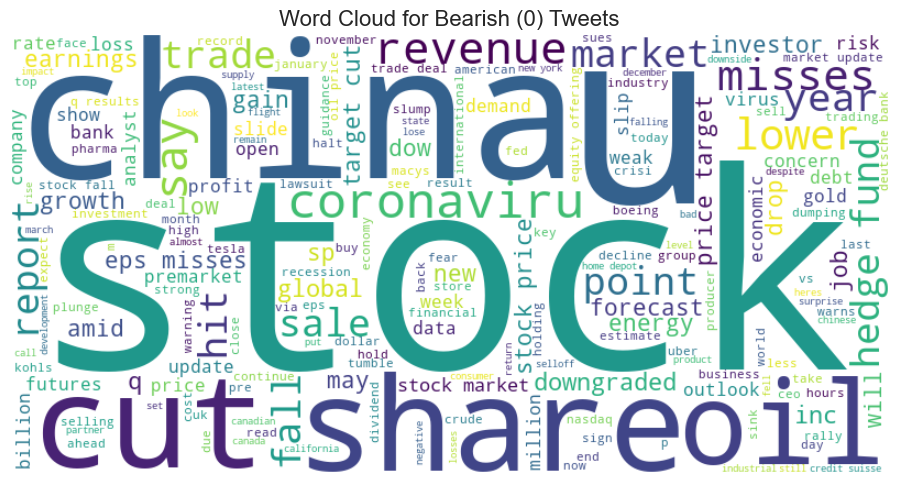

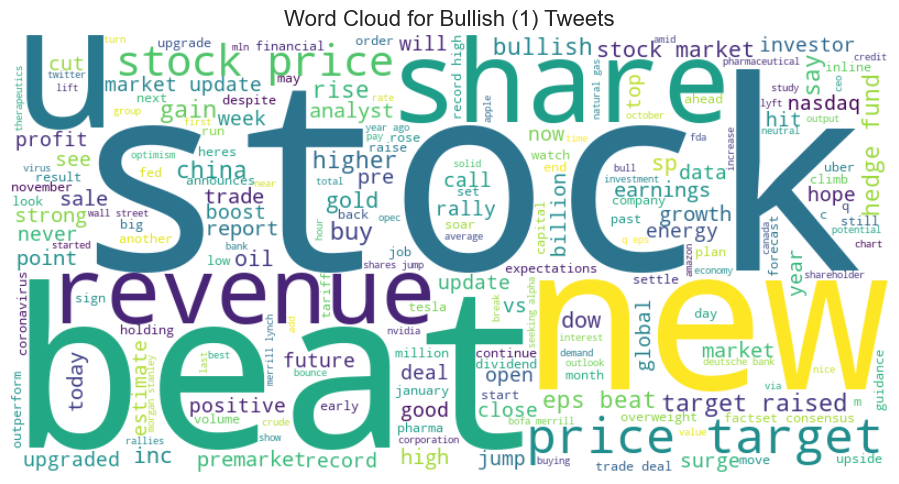

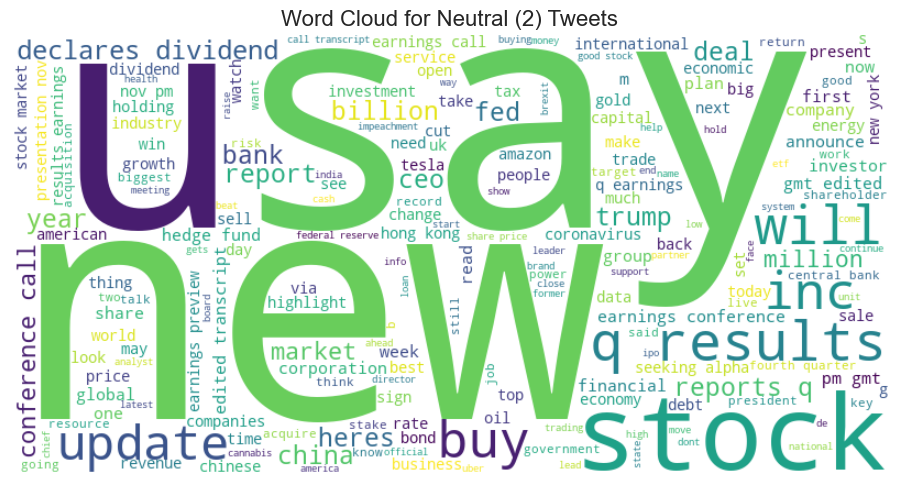

In [68]:
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')

In [69]:
# Create a character count column
df_train['char_count'] = df_train['text'].apply(len)

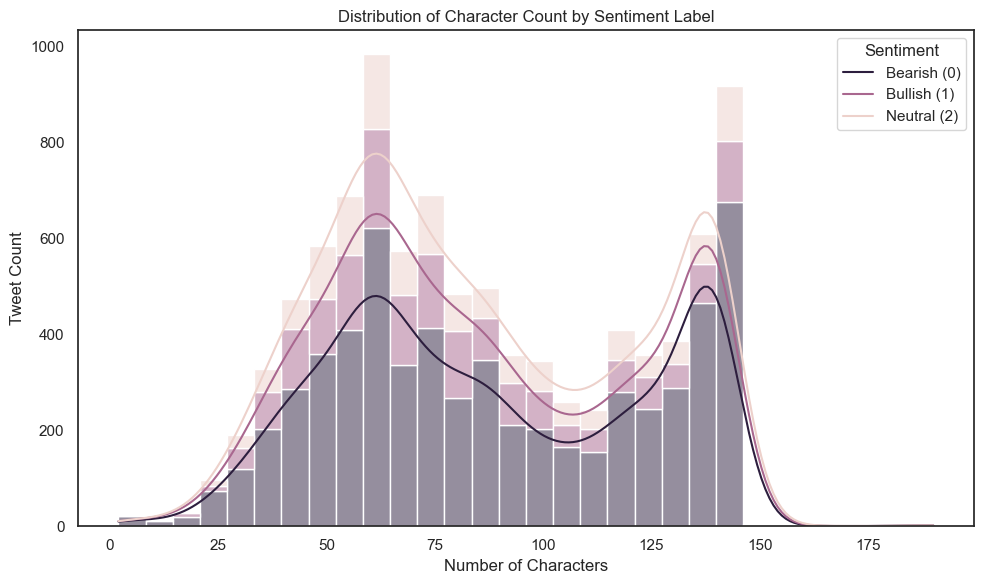

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

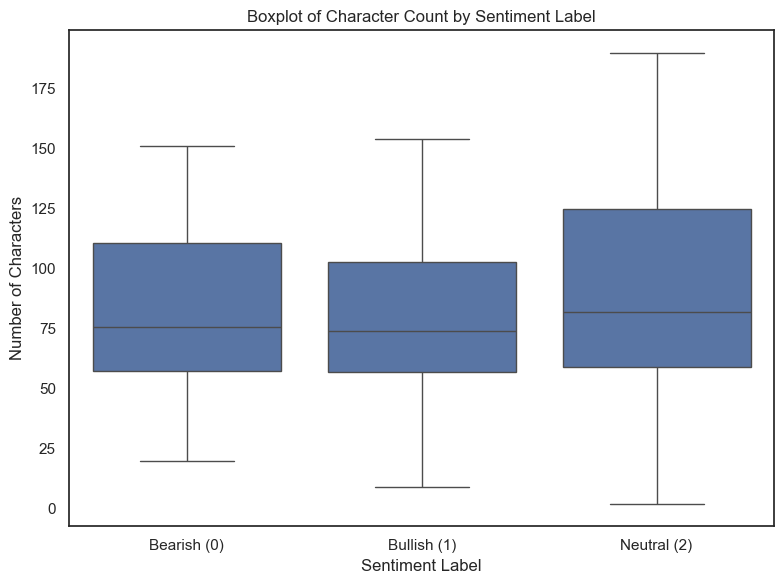

In [71]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [72]:
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])

In [73]:
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()

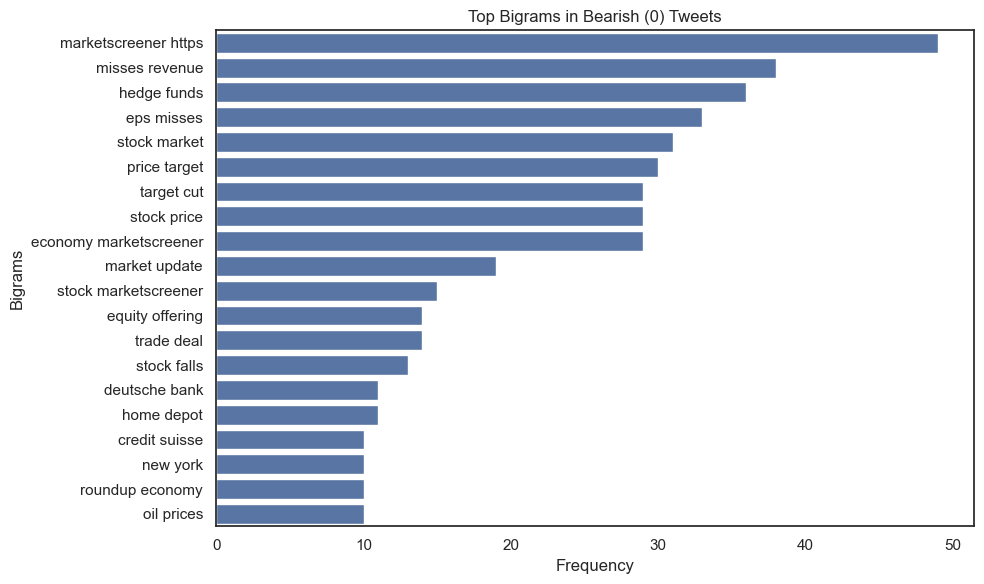

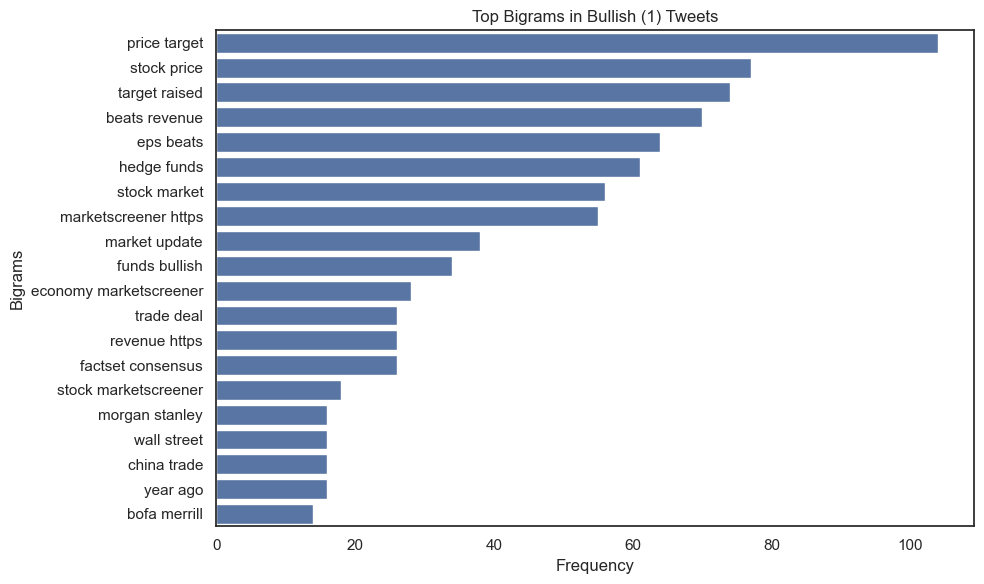

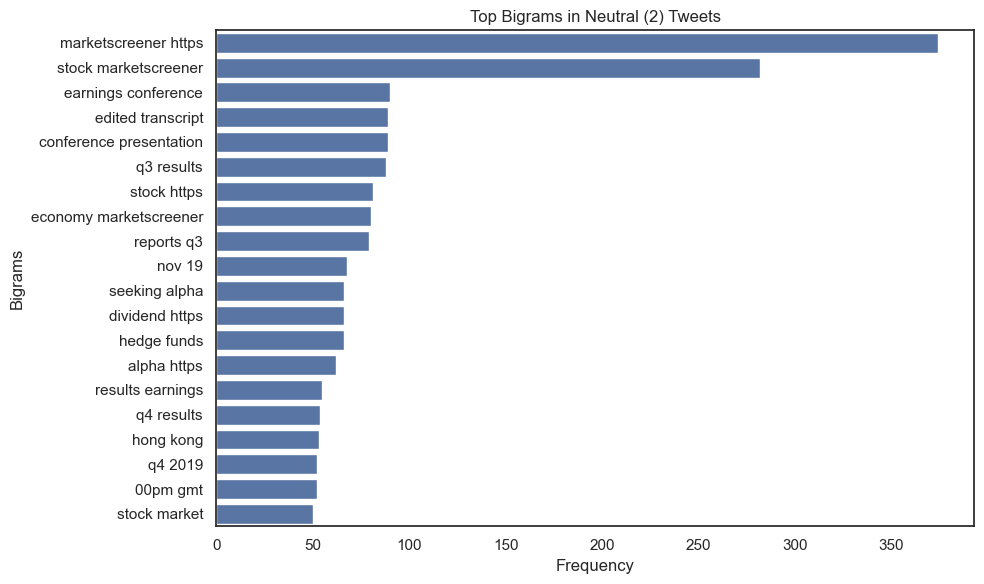

In [74]:
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))

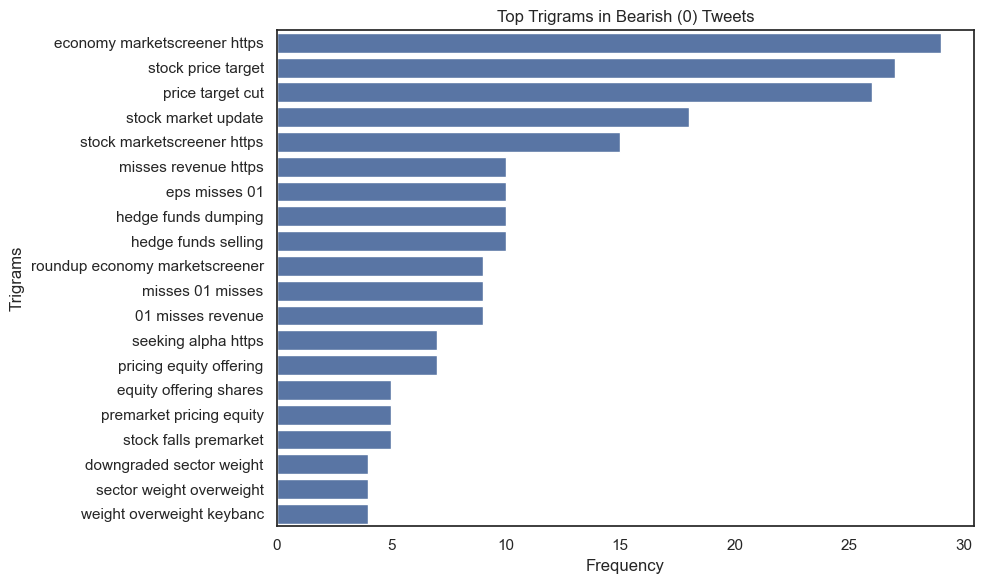

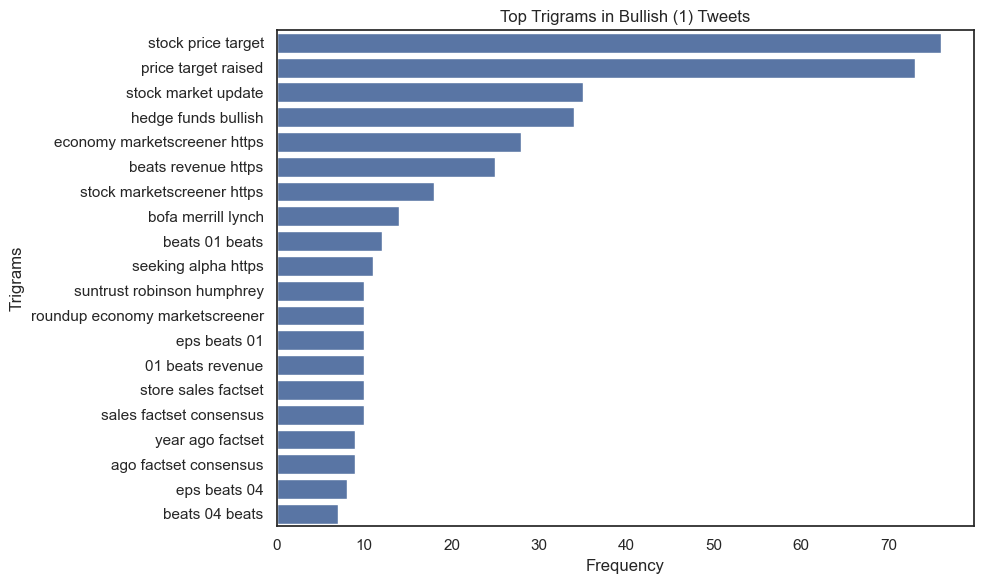

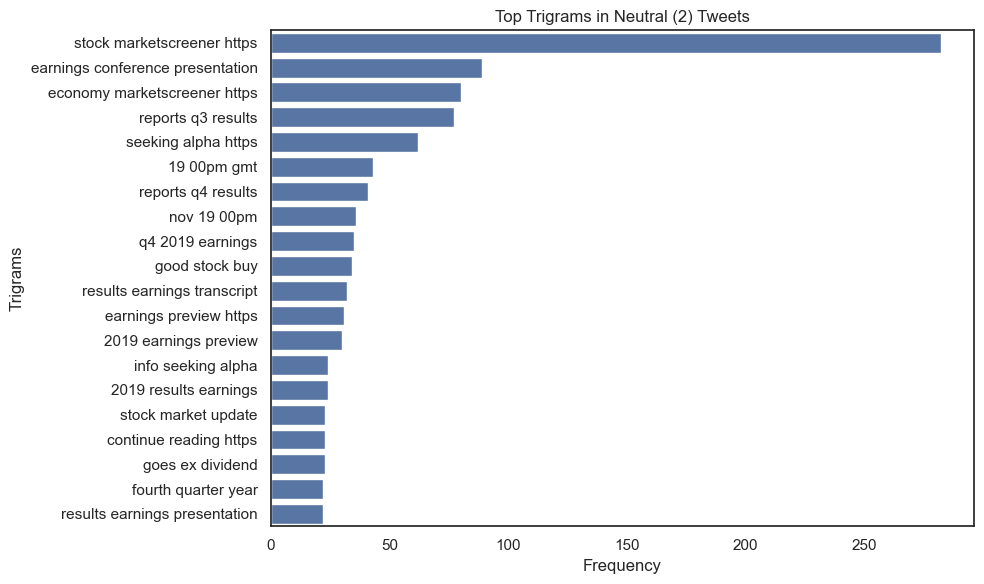

In [75]:
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))

In [76]:
# Function to get top TF-IDF terms
def get_top_tfidf_terms(corpus, top_n=20, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    X = tfidf.fit_transform(corpus)
    scores = X.sum(axis=0).A1
    terms = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame({'term': terms, 'score': scores})
    top_terms = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return top_terms

In [77]:
# Function to plot top TF-IDF terms
def plot_top_tfidf_terms(tfidf_df, title='Top TF-IDF Terms'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='term', data=tfidf_df)
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

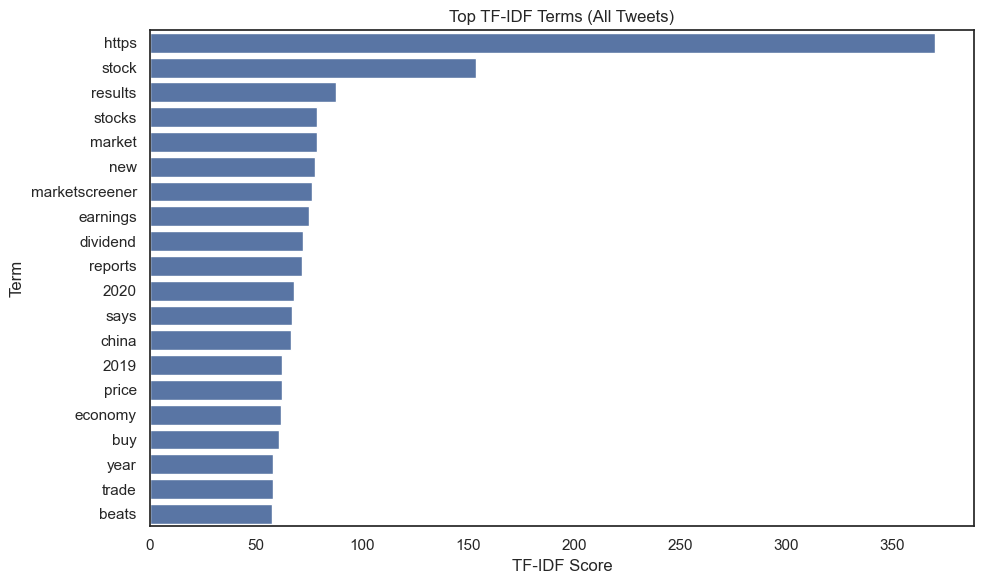

In [78]:
global_tfidf = get_top_tfidf_terms(df_train['text'].str.lower(), top_n=20)
plot_top_tfidf_terms(global_tfidf, title='Top TF-IDF Terms (All Tweets)')

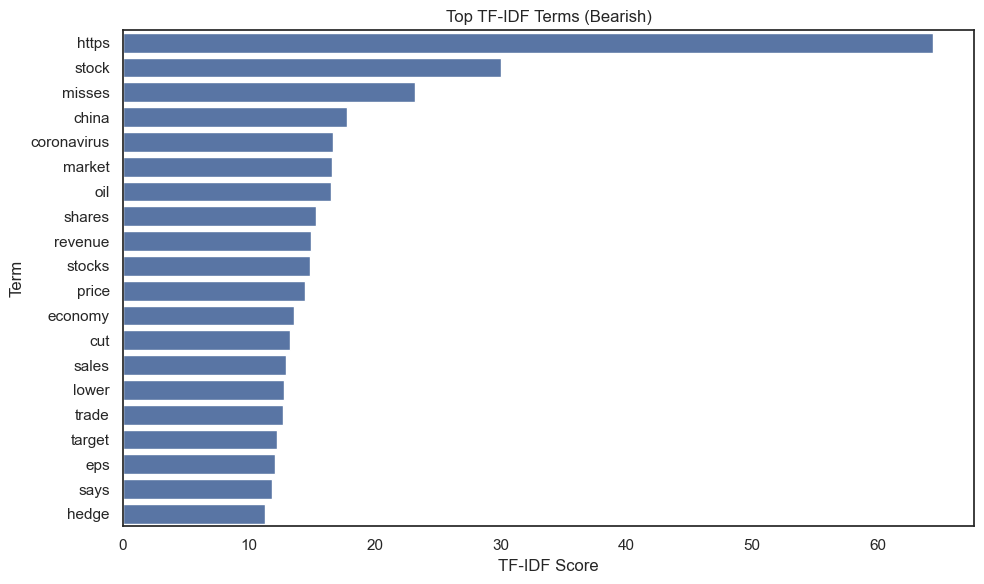

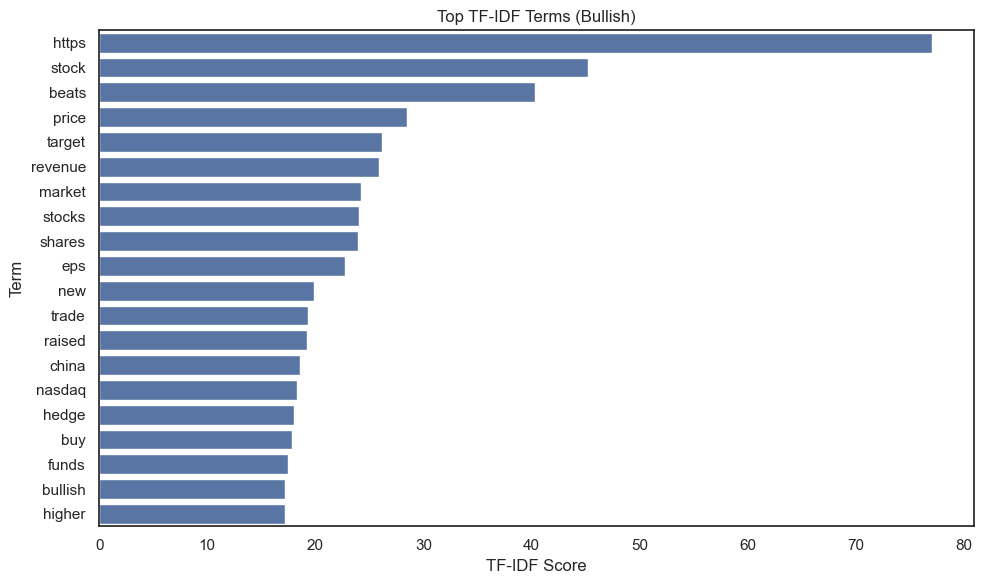

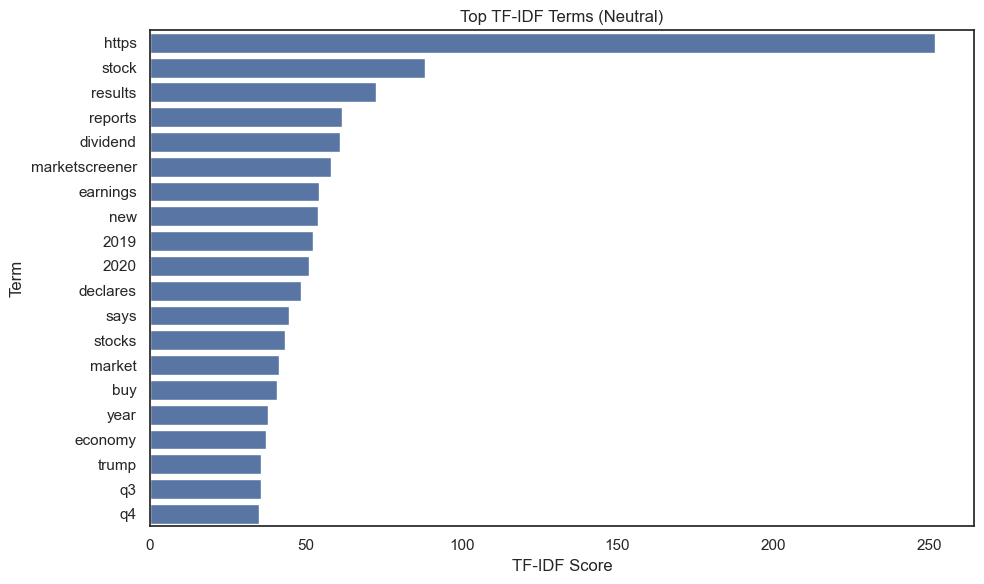

In [79]:
# Bearish (0)
bearish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 0]['text'].str.lower())
plot_top_tfidf_terms(bearish_tfidf, title='Top TF-IDF Terms (Bearish)')

# Bullish (1)
bullish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 1]['text'].str.lower())
plot_top_tfidf_terms(bullish_tfidf, title='Top TF-IDF Terms (Bullish)')

# Neutral (2)
neutral_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 2]['text'].str.lower())
plot_top_tfidf_terms(neutral_tfidf, title='Top TF-IDF Terms (Neutral)')

<a class="anchor" id="chapter3"></a>

# 3. Data Split

</a>

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['label'], test_size=0.20, random_state=4)

In [81]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7634, 1909, 7634, 1909)

<a class="anchor" id="chapter4"></a>

# 4. Data Preprocessing

</a>

In [82]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chloedeschanel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chloedeschanel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chloedeschanel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chloedeschanel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [83]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [84]:
def preprocess_text(text, do_lemmatize=True, do_stem=False):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Regex Cleaning
    text = re.sub(r"http\S+|www\S+", '', text)                         # Remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)                            # Remove mentions and hashtags
    text = re.sub(r"br", "", text)                                     # Remove 'br' (e.g. <br> tags)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)     # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)                           # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                           # Remove extra whitespace

    # 3. Tokenization
    tokens = nltk.word_tokenize(text)

    # 4. Stop word removal
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization and Stemming
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    if do_stem:
        tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)

In [85]:
X_train_cleaned = X_train.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))
X_test_cleaned = X_test.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))

In [89]:
# Check before and after cleaning
print("Original tweet:\n", X_train.iloc[6])
print("Cleaned tweet:\n", X_train_cleaned.iloc[6])

Original tweet:
 Hedge Funds Open Kimono: 5 Most Popular Software Stocks Right Now
Cleaned tweet:
 hedge fund open kimono popular software stock right


<a class="anchor" id="chapter5"></a>

# 5. Feature Engineering

</a>

<a class="anchor" id="sub-section-5_1"></a>

## 5.1. BoW

</a>

In [92]:
def extract_bow_features(train_texts, test_texts):
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_test, vectorizer

In [93]:
BoW_X_train, BoW_X_test, bow_vectorizer = extract_bow_features(X_train_cleaned, X_test_cleaned)

In [94]:
term_counts = np.array(BoW_X_train.sum(axis=0)).flatten()
terms = bow_vectorizer.get_feature_names_out()
top_terms_df = pd.DataFrame({'term': terms, 'count': term_counts}).sort_values(by='count', ascending=False)

In [96]:
top_terms_df.head(10)

,term,count
10475,stock,673
6577,market,318
9640,say,317
9185,report,317
7332,new,313
8606,price,300
9259,result,300
3344,earnings,281
9896,share,277
5341,inc,256


<a class="anchor" id="sub-section-5_2"></a>

## 5.2. TF-IDF

</a>

In [97]:
def extract_tfidf_features(train_texts, test_texts):
    vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_test = vectorizer.transform(test_texts).toarray()
    return X_train, X_test, vectorizer

In [113]:
tfidf_X_train, tfidf_X_test, tfidf_vectorizer = extract_tfidf_features(X_train_cleaned, X_test_cleaned)

In [99]:
# View top 10 IDF values
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
list(idf_dict.items())[4100:4110]

[('fighter', 8.841885928984624),
 ('fighting', 9.247351037092788),
 ('figrx', 9.247351037092788),
 ('figure', 8.148738748424677),
 ('figured', 9.247351037092788),
 ('file', 7.107284873596517),
 ('filed', 8.148738748424677),
 ('filer', 9.247351037092788),
 ('filing', 8.554203856532842),
 ('fill', 8.841885928984624)]

<a class="anchor" id="sub-section-5_3"></a>

## 5.3. Word2Vec

</a>

In [101]:
def get_average_word2vec(texts, model):
    features = []
    for text in texts:
        words = text.split()
        valid_words = [model.wv[word] for word in words if word in model.wv]
        if valid_words:
            avg = np.mean(valid_words, axis=0)
        else:
            avg = np.zeros(model.vector_size)
        features.append(avg)
    return np.array(features)

In [102]:
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_test = [text.split() for text in X_test_cleaned]

In [103]:
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)

In [104]:
word2vec_X_train = get_average_word2vec(X_train_cleaned, w2v_model)
word2vec_X_test = get_average_word2vec(X_test_cleaned, w2v_model)

<a class="anchor" id="sub-section-5_4"></a>

## 5.4. Transformer (BERT)

</a>

<a class="anchor" id="sub-section-5_5"></a>

## 5.5. Extra method 1

</a>

<a class="anchor" id="sub-section-5_6"></a>

## 5.6. Extra method 2

</a>

<a class="anchor" id="chapter6"></a>

# 6. Models

</a>

<a class="anchor" id="sub-section-6_1"></a>

## 6.1. KNN

</a>

In [133]:
# For evaluation
def evaluate_classification(feature_used, y_true, y_pred):
    print("Evaluation metrics with", feature_used, "features.")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

**WITH BOW**

In [134]:
BoW_knn = KNeighborsClassifier(n_neighbors=5)
BoW_knn.fit(BoW_X_train, y_train)
y_pred = BoW_knn.predict(BoW_X_test)

In [135]:
evaluate_classification("BoW", y_test, y_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7077003666841278
Precision (macro): 0.7168072435368033
Recall (macro): 0.44217791741384116
F1 Score (macro): 0.45701743022468005

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7308    0.1372    0.2310       277
           1     0.7130    0.2037    0.3169       378
           2     0.7067    0.9856    0.8232      1254

    accuracy                         0.7077      1909
   macro avg     0.7168    0.4422    0.4570      1909
weighted avg     0.7114    0.7077    0.6370      1909



**WITH TF-IDF**

In [136]:
tfidf_knn = KNeighborsClassifier(n_neighbors=5)
tfidf_knn.fit(tfidf_X_train, y_train)
y_pred = tfidf_knn.predict(tfidf_X_test)

In [137]:
evaluate_classification("TF-IDF", y_test, y_pred)

Evaluation metrics with TF-IDF features.
Accuracy: 0.6856993190151912
Precision (macro): 0.7722433702825859
Recall (macro): 0.39038040469416746
F1 Score (macro): 0.3741693997379148

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.8095    0.0614    0.1141       277
           1     0.8269    0.1138    0.2000       378
           2     0.6803    0.9960    0.8084      1254

    accuracy                         0.6857      1909
   macro avg     0.7722    0.3904    0.3742      1909
weighted avg     0.7281    0.6857    0.5872      1909



**WITH WORD2VEC**

In [138]:
word2vec_knn = KNeighborsClassifier(n_neighbors=5)
word2vec_knn.fit(word2vec_X_train, y_train)
y_pred = word2vec_knn.predict(word2vec_X_test)

In [139]:
evaluate_classification("Word2Vec", y_test, y_pred)

Evaluation metrics with Word2Vec features.
Accuracy: 0.6270298585646935
Precision (macro): 0.4582231460454667
Recall (macro): 0.445839022918002
F1 Score (macro): 0.45002908964719507

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.2557    0.2022    0.2258       277
           1     0.3697    0.3228    0.3446       378
           2     0.7493    0.8126    0.7796      1254

    accuracy                         0.6270      1909
   macro avg     0.4582    0.4458    0.4500      1909
weighted avg     0.6025    0.6270    0.6131      1909



- BoW is currently the best-performing model overall (highest accuracy and decent balance). 
- TF-IDF may be best if prioritize precision (e.g., fewer false alarms).
- Word2Vec might help if you're more concerned with not missing any relevant tweets (higher recall).

To improve recall and F1 score across the board?
- Using ensemble methods or hyperparameter tuning
- Balancing the dataset or applying class weights
- Trying more powerful embeddings (e.g., BERT, as you're planning next)